In [1]:
import os, sys, time

print(sys.version)
print(os.path.realpath(os.curdir))

!hostname
!whoami

3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
/home/jovyan/work
6c8294df6523
jovyan


In [2]:
from functools import reduce
from glob import glob
from pprint import pprint

import bokeh.plotting as bk
import bokeh.io
import bokeh.palettes
bk.output_notebook()

import ipywidgets as ipw

import matplotlib.style
matplotlib.style.use('ggplot')
import matplotlib.pyplot as mpl

import numpy as np
import pandas as pd

Loading BokehJS ...

In [3]:
DATAFILES = glob('data/quantquote_daily_sp500_83986/daily/*.csv')
DATAFILES.sort()

In [4]:
tstart = time.clock()

DATA = {}
SYMBOLS = []
COLUMNS = ['date', 'zero', 'open', 'high', 'low', 'close', 'volatility']
for filepath in DATAFILES:
    symbol = filepath.split('/')[-1].split('_')[-1][:-4]
    df = pd.read_csv(filepath,
                     header=None,
                     names=COLUMNS,
                     index_col=0,
                     parse_dates=[0])
    DATA[symbol] = df
    SYMBOLS.append(symbol)

print('%d stocks loaded...' % (len(DATA.keys()),))

tend = time.clock()
print('%fs elapsed...' % (tend - tstart,))

500 stocks loaded...
2.053158s elapsed...


In [5]:
dateranges = list(map(lambda key: [DATA[key].index[0], DATA[key].index[-1],  len(DATA[key].index)], DATA))
MINDATE = reduce(lambda a, b: min(a, b), map(lambda r: r[0], dateranges))
MAXDATE = reduce(lambda a, b: max(a, b), map(lambda r: r[1], dateranges))
MAXSAMPLE = reduce(lambda a, b: max(a, b), map(lambda r: r[2], dateranges))

In [6]:
def mpl_plot_serie(data, symbol, column='open', window=7, start=None, end=None, mean=True, std=False, envelope=True, center=False, figsize=(12,8)):

    if not start:
        start = data[symbol].index[0]

    if not end:
        end = data[symbol].index[-1]

    column_mean = '%s_mean' % (column,)
    column_std = '%s_std' % (column,)

    df = pd.DataFrame()
    df[column] = data[symbol][column][start:end].copy()
    df[column_mean] = df[column].rolling(window=window, center=center).mean()
    df[column_std] = df[column].rolling(window=window, center=center).std()

    mpl.figure(figsize=figsize)
    mpl.plot(df.index, df[column], label=symbol.upper())
    if mean:
        mpl.plot(df.index, df[column_mean], label='mean')
    if std:
        mpl.plot(df.index, df[column_std], label='std')
    if envelope:
        mpl.fill_between(df.index,
                         df[column_mean] - 2 * df[column_std],
                         df[column_mean] + 2 * df[column_std],
                         label='mean +/- 2 * std',
                         color='b',
                         alpha=0.2)
    mpl.title(symbol.upper())
    mpl.legend(loc='best')
    mpl.show()

In [7]:
BK_HANDLE = None
BK_FIGURES = None
BK_FIGURE = None
BK_AXES = None
BK_DATA = None

def bk_plot_serie(data, 
                  symbol, 
                  column='open', 
                  window=7, 
                  start=None, 
                  end=None, 
                  mean=True, 
                  std=False, 
                  envelope=True,  
                  center=False,
                  interactive=False,
                  width=600,
                  height=300):

    global BK_HANDLE
    global BK_FIGURE
    global BK_AXES
    global BK_DATA
    
    _symbol = symbol.upper()
    
    if not start:
        start = data[symbol].index[0]

    if not end:
        end = data[symbol].index[-1]

    column_mean = '%s_mean' % (column,)
    column_std = '%s_std' % (column,)

    df = pd.DataFrame()
    df[column] = data[symbol][column][start:end].copy()
    df[column_mean] = df[column].rolling(window=window, center=center).mean()
    df[column_std] = df[column].rolling(window=window, center=center).std()

    axes = []
    legend_items = []
    palette = bokeh.palettes.plasma(256)
    figure = bk.figure(title=symbol.upper(), x_axis_type="datetime", width=width, height=height)
    figure.x_range.range_padding = 0
    axes.append(figure.line(df.index, df[column], line_color=palette[128]))
    legend_items.append((_symbol, [axes[0]]))
    if mean:
        axes.append(figure.line(df.index, df[column_mean], line_color=palette[0]))
        legend_items.append(('mean', [axes[1]]))
    else:
        axes.append(None)
        
    if std:
        axes.append(figure.line(df.index, df[column_std], line_color=palette[192]))
        legend_items.append(('std', [axes[2]]))
    else:
        axes.append(None)

    if envelope:
        upperband = df[column_mean] + 2 * df[column_std]
        lowerband = df[column_mean] - 2 * df[column_std]
        x_data = df.index     
        band_x = np.append(x_data, x_data[::-1])
        band_y = np.append(lowerband, upperband[::-1])
        axes.append(figure.patch(band_x, band_y, color=palette[32], alpha=0.2))
        legend_items.append(('mean +/- 2 * std', [axes[3]]))
    else:
        axes.append(None)

    legend = bokeh.models.Legend(items=legend_items, location=(30, 100))
    figure.add_layout(legend, 'right')
        
    handle = bk.show(figure, notebook_handle=interactive)
    
    BK_HANDLE = handle
    BK_FIGURE = figure
    BK_AXES = axes
    BK_DATA = data

def bk_update_serie(_symbol, 
                    column='open', 
                    window=7, 
                    start=None, 
                    end=None,
                    center=False):

    global BK_HANDLE
    global BK_FIGURE
    global BK_AXES
    global BK_DATA
    
    handle = BK_HANDLE
    figure = BK_FIGURE
    axes = BK_AXES
    data = BK_DATA
    
    symbol = _symbol.lower()
    
    if not start:
        start = data[symbol].index[0]

    if not end:
        end = data[symbol].index[-1]

    column_mean = '%s_mean' % (column,)
    column_std = '%s_std' % (column,)

    df = pd.DataFrame()
    df[column] = data[symbol][column][start:end].copy()
    df[column_mean] = df[column].rolling(window=window, center=center).mean()
    df[column_std] = df[column].rolling(window=window, center=center).std()

    axes[0].data_source.data['x'] = df.index
    axes[0].data_source.data['y'] = df[column]
    
    if axes[1]:
        axes[1].data_source.data['x'] = df.index
        axes[1].data_source.data['y'] = df[column_mean]
        
    if axes[2]:
        axes[2].data_source.data['x'] = df.index
        axes[2].data_source.data['y'] = df[column_std]
        
    if axes[3]:
        upperband = df[column_mean] + 2 * df[column_std]
        lowerband = df[column_mean] - 2 * df[column_std]
        x_data = df.index
        band_x = np.append(x_data, x_data[::-1])
        band_y = np.append(lowerband, upperband[::-1])
        axes[3].data_source.data['x'] = band_x
        axes[3].data_source.data['y'] = band_y
    
    figure.title.text = _symbol
    figure.legend[0].items[0].label['value'] = _symbol
    
    bokeh.io.push_notebook(handle=handle)

def bk_plot_series(data, 
                   symbols, 
                   column='open', 
                   window=7, 
                   start=None, 
                   end=None, 
                   mean=True, 
                   std=False, 
                   envelope=True,  
                   center=False,
                   interactive=False,
                   width=600,
                   height=300):

    global BK_HANDLE
    global BK_FIGURES
    global BK_AXES
    global BK_DATA
        
    if not start:
        for symbol in symbols:
            start = MAXDATE
            if data[symbol].index[0] < start:
                start = data[symbol].index[0]

    if not end:
        for symbol in symbols:
            end = MINDATE
            if data[symbol].index[-1] > end:
                end = data[symbol].index[-1]

    column_mean = '%s_mean' % (column,)
    column_std = '%s_std' % (column,)

    first = None
    figures = []
    _axes = {}
    for i, symbol in enumerate(symbols):
        _symbol = symbol.upper()
        
        df = pd.DataFrame()
        df[column] = data[symbol][column][start:end].copy()
        df[column_mean] = df[column].rolling(window=window, center=center).mean()
        df[column_std] = df[column].rolling(window=window, center=center).std()
        
        axes = []
        legend_items = []
        palette = bokeh.palettes.plasma(256)
        if first is None:
            figure = bk.figure(title=symbol.upper(), x_axis_type="datetime", width=width, height=height)
            first = figure
        else:
            figure = bk.figure(title=symbol.upper(), x_axis_type="datetime", x_range=first.x_range, width=width, height=height)
        figure.x_range.range_padding = 0 
        axes.append(figure.line(df.index, df[column], line_color=palette[128]))
        legend_items.append((_symbol, [axes[0]]))
        if mean:
            axes.append(figure.line(df.index, df[column_mean], line_color=palette[0]))
            legend_items.append(('mean', [axes[1]]))
        else:
            axes.append(None)

        if std:
            axes.append(figure.line(df.index, df[column_std], line_color=palette[192]))
            legend_items.append(('std', [axes[2]]))
        else:
            axes.append(None)

        if envelope:
            upperband = df[column_mean] + 2 * df[column_std]
            lowerband = df[column_mean] - 2 * df[column_std]
            x_data = df.index     
            band_x = np.append(x_data, x_data[::-1])
            band_y = np.append(lowerband, upperband[::-1])
            axes.append(figure.patch(band_x, band_y, color=palette[32], alpha=0.2))
            legend_items.append(('mean +/- 2 * std', [axes[3]]))
        else:
            axes.append(None)

        legend = bokeh.models.Legend(items=legend_items, location=(30, 100))
        figure.add_layout(legend, 'right')

        _axes[i] = axes
        figures.append(figure)
        
    handle = bk.show(bokeh.layouts.column(figures), notebook_handle=interactive)
    
    BK_HANDLE = handle
    BK_FIGURES = figures
    BK_AXES = _axes
    BK_DATA = data

def bk_update_series(symbols=[], 
                     column='open', 
                     window=7, 
                     start=None, 
                     end=None,
                     center=False,
                     symbol1=[],
                     symbol2=[],
                     symbol3=[],
                     symbol4=[],
                     symbol5=[]):

    global BK_HANDLE
    global BK_FIGURES
    global BK_AXES
    global BK_DATA
    
    handle = BK_HANDLE
    figures = BK_FIGURES
    _axes = BK_AXES
    data = BK_DATA
    
    if symbols is None:
        symbols = filter(lambda s: s is not None, [symbol1, symbol2, symbol3, symbol4, symbol5])
        
    if not start:
        for symbol in symbols:
            start = MAXDATE
            if data[symbol].index[0] < start:
                start = data[symbol].index[0]

    if not end:
        for symbol in symbols:
            end = MINDATE
            if data[symbol].index[-1] > end:
                end = data[symbol].index[-1]

    column_mean = '%s_mean' % (column,)
    column_std = '%s_std' % (column,)

    for i, _symbol in enumerate(symbols):
        symbol = _symbol.lower()
        figure = figures[i]
        axes = _axes[i]
        
        df = pd.DataFrame()
        df[column] = data[symbol][column][start:end].copy()
        df[column_mean] = df[column].rolling(window=window, center=center).mean()
        df[column_std] = df[column].rolling(window=window, center=center).std()

        axes[0].data_source.data['x'] = df.index
        axes[0].data_source.data['y'] = df[column]

        if axes[1]:
            axes[1].data_source.data['x'] = df.index
            axes[1].data_source.data['y'] = df[column_mean]

        if axes[2]:
            axes[2].data_source.data['x'] = df.index
            axes[2].data_source.data['y'] = df[column_std]

        if axes[3]:
            upperband = df[column_mean] + 2 * df[column_std]
            lowerband = df[column_mean] - 2 * df[column_std]
            x_data = df.index
            band_x = np.append(x_data, x_data[::-1])
            band_y = np.append(lowerband, upperband[::-1])
            axes[3].data_source.data['x'] = band_x
            axes[3].data_source.data['y'] = band_y

        figure.title.text = _symbol
        figure.legend[0].items[0].label['value'] = _symbol
    
    bokeh.io.push_notebook(handle=handle)

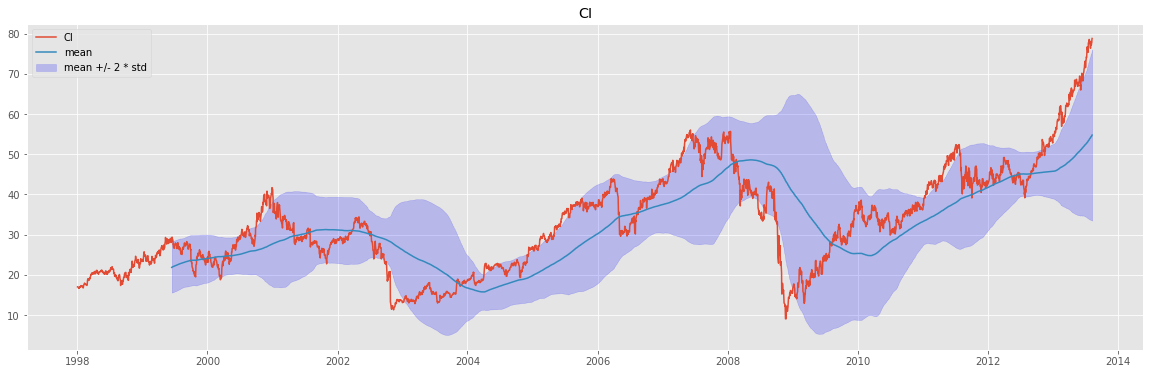

In [8]:
SYMBOL = SYMBOLS[np.random.randint(len(SYMBOLS))]

WINDOW = 365

START   = MINDATE
END     = MAXDATE

COLUMN = 'open'

mpl_plot_serie(DATA, SYMBOL, window=WINDOW, start=START, end=END, figsize=(20,6))

In [9]:
# WINDOW = 365

# START   = MINDATE
# END     = MAXDATE

# COLUMN = 'open'

# bk_plot_serie(DATA, SYMBOL, window=WINDOW, start=START, end=END, interactive=True, width=1100, height=200)

In [10]:
# ipw.interact(bk_update_serie,
#              _symbol=ipw.Select(options=list(map(lambda s: s.upper(), SYMBOLS)), value=SYMBOL.upper()),
#              column=ipw.Select(options=COLUMNS, value='open'),
#              window=ipw.SelectionSlider(options=(7, 15, 30, 60, 90, 180, 365), value=WINDOW),
#              start=ipw.DatePicker(value=START),
#              end=ipw.DatePicker(value=END))

In [11]:
# SYMBOL1 = 'aapl'
# SYMBOL2 = 'goog'
# SYMBOL3 = 'nflx'
# SYMBOL4 = 'amzn'
# SYMBOL5 = 'ibm'

# WINDOW = 365

# START   = MINDATE
# END     = MAXDATE

# COLUMN = 'open'

# bk_plot_series(DATA, (SYMBOL1, SYMBOL2, SYMBOL3, SYMBOL4, SYMBOL5), window=WINDOW, interactive=True, width=700, height=200)

In [12]:
# ipw.interact(bk_update_series,
#              symbol1=ipw.Select(options=list(map(lambda s: s.upper(), SYMBOLS)), value=SYMBOL1.upper()),
#              symbol2=ipw.Select(options=list(map(lambda s: s.upper(), SYMBOLS)), value=SYMBOL2.upper()),
#              symbol3=ipw.Select(options=list(map(lambda s: s.upper(), SYMBOLS)), value=SYMBOL3.upper()),
#              symbol4=ipw.Select(options=list(map(lambda s: s.upper(), SYMBOLS)), value=SYMBOL4.upper()),
#              symbol5=ipw.Select(options=list(map(lambda s: s.upper(), SYMBOLS)), value=SYMBOL5.upper()),
#              column=ipw.Select(options=COLUMNS, value='open'),
#              window=ipw.SelectionSlider(options=(7, 15, 30, 60, 90, 180, 365), value=WINDOW),
#              start=ipw.DatePicker(value=START),
#              end=ipw.DatePicker(value=END))
# None